# SAE-EAP Main Demo

This notebook serves as the main overview of SAE-EAP features. 

## Setup

In [1]:
# Load model

from sae_eap.model.load_pretrained import load_model

model = load_model('gpt2')

/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/daniel/ml_workspace/sae-eap/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


In [2]:
# Make data handler

from sae_eap.data.ioi import make_ioi_single

handler = make_ioi_single(model)
print(handler)

SinglePromptHandler(
    clean_prompt=When John and Mary went to the shops, John gave a bag to,
    corrupt_prompt= When Alice and Bob went to the shops, Charlie gave a bag to,
    answer= Mary,
    wrong_answer= John
)


In [3]:
# Build graph
from sae_eap.graph import build

graph = build.build_graph(model)

## Edge Attribution Patching

In [4]:
# Run attribution
from sae_eap.runner import run_attribution

attribution = run_attribution(model, graph, handler)

0it [00:00, ?it/s]

1it [00:00,  1.87it/s]
100%|██████████| 32491/32491 [00:00<00:00, 1312401.35it/s]


In [5]:
# Prune graph
from sae_eap.prune import PruningPipeline, ThresholdEdgePruner, DeadNodePruner

model_graph = graph.copy()
pipeline = PruningPipeline([
    ThresholdEdgePruner(0.01),
    DeadNodePruner()
])
pipeline.prune(graph, attribution)
circuit_graph = graph

print(len(circuit_graph.nodes))
print(len(circuit_graph.edges))
print(len(model_graph.nodes))
print(len(model_graph.edges))

586
12813
602
32491


In [6]:
# TODO: Visualize graph

In [7]:
# Run ablation
from sae_eap.runner import run_ablation

faithfulness = run_ablation(model, circuit_graph, model_graph, handler)
print(faithfulness)

[0.8886866569519043]


# Experiments

In [12]:
# Plot faithfulness curve

# Prune graph
from sae_eap.prune import PruningPipeline, TopNEdgePruner, DeadNodePruner

model_graph = build.build_graph(model)
edge_counts = (10, 50, 100, 200, 500, 1000)
faithfulnesses = []
for k_edges in edge_counts:
    graph = model_graph.copy()
    pipeline = PruningPipeline([
        TopNEdgePruner(k_edges),
        DeadNodePruner()
    ])
    pipeline.prune(graph, attribution)
    circuit_graph = graph

    faithfulness = run_ablation(model, circuit_graph, model_graph, handler, setting = "noising")[0]
    print(f"Top {k_edges} edges: faithfulness={faithfulness:.4f}")
    faithfulnesses.append(faithfulness)

Top 10 edges: faithfulness=0.1799
Top 50 edges: faithfulness=0.2846
Top 100 edges: faithfulness=0.3844
Top 200 edges: faithfulness=0.2041
Top 500 edges: faithfulness=0.2378
Top 1000 edges: faithfulness=0.3250


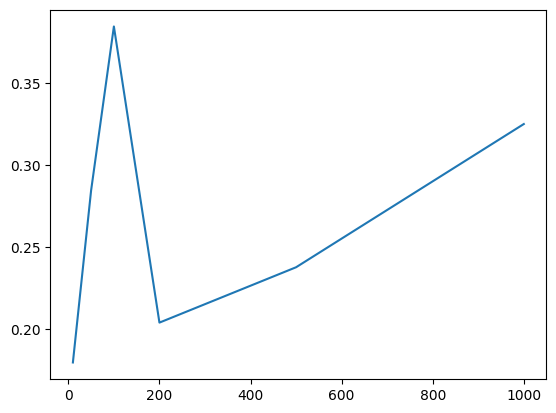

In [13]:
import matplotlib.pyplot as plt 

plt.plot(edge_counts, faithfulnesses)